[캐글](https://www.kaggle.com/competitions/aerial-cactus-identification/data)

# EDA

## 데이터 둘러보기

In [109]:
import pandas as pd

data_path = "./data/aerial_cactus_identification/"
labels = pd.read_csv(data_path + "train.csv")
submissions = pd.read_csv(data_path + "sample_submission.csv")

In [110]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [111]:
submissions.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


## 데이터 시각화

### 타겟값 분포

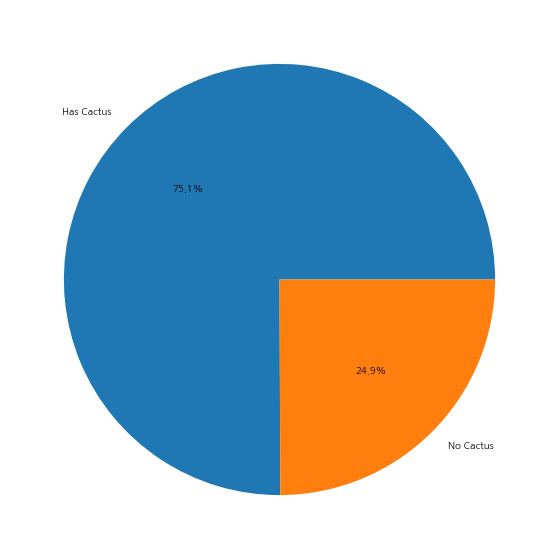

In [112]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.figure(figsize=(7, 7))

label = ["Has Cactus", "No Cactus"]
plt.pie(labels["has_cactus"].value_counts(), labels=label, autopct="%1.1f%%")
plt.show()

### 이미지 출력

In [113]:
from zipfile import ZipFile

# 훈련 이미지 데이터 압축 풀기
with ZipFile(data_path + "train.zip") as z:
    z.extractall(data_path)

# 테스트 이미지 데이터 압축 풀기
with ZipFile(data_path + "test.zip") as z:
    z.extractall(data_path)

In [114]:
import os

num_train = len(os.listdir(data_path + "train"))
num_test = len(os.listdir(data_path + "test"))

print(f"훈련 데이터 개수: {num_train}개")
print(f"테스트 데이터 개수: {num_test}개")

훈련 데이터 개수: 17500개
테스트 데이터 개수: 4000개


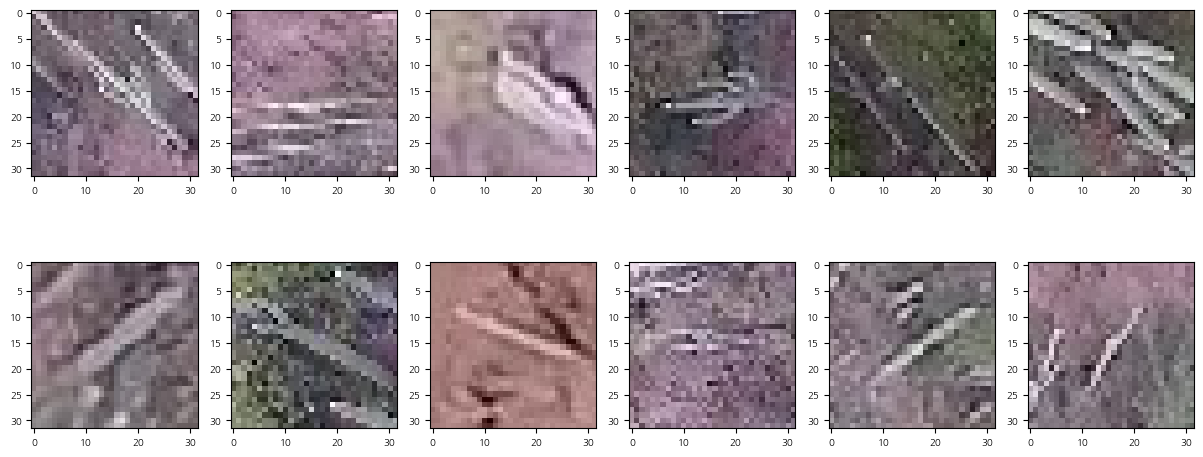

In [115]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc("font", size=7)
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

# 선인장을 포함하는 이미지 파일명(마지막 12개)
last_has_cactus_img_name = labels[labels["has_cactus"] == 1]["id"][-12:]

# 이미지 출력
for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = "train/" + img_name
    img = cv2.imread(data_path + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 이미지 색상 보정
    ax = plt.subplot(grid[idx])
    ax.imshow(img)

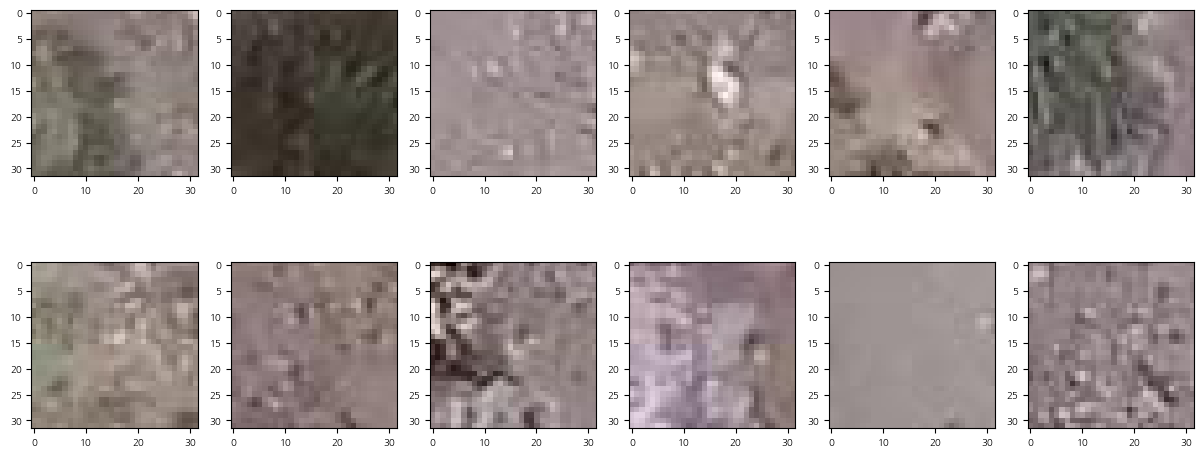

In [116]:
mpl.rc("font", size=7)
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

# 선인장을 포함하는 이미지 파일명(마지막 12개)
last_has_cactus_img_name = labels[labels["has_cactus"] == 0]["id"][-12:]

# 이미지 출력
for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = "train/" + img_name
    img = cv2.imread(data_path + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 이미지 색상 보정
    ax = plt.subplot(grid[idx])
    ax.imshow(img)

In [117]:
img.shape  # 가로 픽셀 수, 세로 픽셀 수, 채널 수(RGB 3개)

(32, 32, 3)

# 베이스라인 모델

1. 시드값 고정 및 GPU 장비 설정
2. 데이터 준비
    1. 훈련/검증 데이터 분리
    2. 데이터셋 클래스 정의
    3. 데이터셋 생성
    4. 데이터 로더 생성
3. 모델 생성(CNN)
4. 모델 훈련
    1. 손실 함수와 옵티마이저 설정
    2. 모델 훈련
5. 성능 검증
6. 예측 및 제출

## 1. 시드값 고정 및 GPU 장비 설정

In [118]:
import torch

print(f"MPS 장치를 지원하도록 build가 되었는가? ㅠ{torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}")

MPS 장치를 지원하도록 build가 되었는가? ㅠTrue
MPS 장치가 사용 가능한가? True


In [119]:
device = torch.device("mps")

In [120]:
import torch
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)  # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)  # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)  # 파이토치 난수 생성기 시드 고정
torch.mps.manual_seed(seed)  # 파이토치 MPS 난수 생성기 시드 고정
torch.backends.mps.deterministic = True  # MPS 장치에서 결정론적 연산을 사용하도록 설정
torch.backends.mps.benchmark = False  # MPS 장치에서 연산 속도를 측정하지 않도록 설정
torch.backends.mps.enabled = True  # MPS 장치를 사용하도록 설정

## 2. 데이터 준비
- 훈련/검증 데이터 분리
- 데이터셋 클래스 정의
- 데이터셋 생성
- 데이터 로더 생성


### 훈련 데이터, 검증 데이터 분리

In [121]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(
    labels, stratify=labels["has_cactus"], test_size=0.1, random_state=seed
)

In [122]:
print(f"훈련 데이터 개수: {len(train)}개")
print(f"검증 데이터 개수: {len(valid)}개")

훈련 데이터 개수: 15750개
검증 데이터 개수: 1750개


### 데이터셋 클래스 정의

- 파이토치로 신경망 모델을 구축하려면 데이터셋도 일정한 형식에 맞게 정의해줘야 함

In [123]:
import cv2
from torch.utils.data import Dataset  # 데이터 생성을 위한 클래스

- Dataset은 추상 클래스이며, Dataset을 상속받은 다음 특수 메서드인 `__len__`과 `__getitem__`을 재정의(오버라이딩)해야 함
    - `__len__`: 데이터셋의 총 데이터 수를 반환
    - `__getitem__`: 인덱스를 전달받아 해당하는 데이터를 반환

In [124]:
data_path

'./data/aerial_cactus_identification/'

In [125]:
class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir="./", transform=None):
        super().__init__()
        self.df = df
        self.img_dir = data_path + img_dir
        self.transform = transform

    # 데이터셋 크기 반환 메서드
    def __len__(self):
        return len(self.df)

    # 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]  # 이미지 ID
        img_path = self.img_dir + img_id  # 이미지 파일 경로
        img = cv2.imread(img_path)  # 이미지 파일 읽기
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 이미지 색상 보정
        label = self.df.iloc[idx, 1]  # 이미지 레이블(타겟값)

        if self.transform is not None:
            img = self.transform(img)  # 변환기가 있다면 이미지 변환기
        return img, label

### 데이터셋 생성

- 파이토치 모델로 이미지를 다루려면 이미지 데이터를 tensor 타입으로 바꿔야 함
- 파이토치로 이미지를 처리할 때는 형상이 (채널 수, 가로픽셀 수, 세로픽셀 수) 순서여야 함
    - 여기에 배치가 추가된다면 (배치 크기, 채널 수, 가로픽셀 수, 세로픽셀 수)가 됨

In [126]:
import torchvision.transforms as transforms  # 이미지 변환을 위한 모듈

transform = transforms.ToTensor()

In [127]:
dataset_train = ImageDataset(df=train, img_dir="train/", transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir="train/", transform=transform)

### 데이터 로더 생성

- 지정한 배치 크기만큼씩 데이터를 불러오는 객체
- 딥러닝 모델을 훈련할 때는 주로 배치 단위로 데이터를 가져와 훈련함(묶음 단위로 훈련하는 게 훨씬 빠르기 때문)


In [128]:
from torch.utils.data import DataLoader

loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=False)

- 배치 크기는 2의 제곱수로 설정하는 게 효율적

## 3. 모델 생성(CNN)

- CNN모델은 nn.Module을 상속해 정의

In [129]:
import torch.nn as nn  # 신경망 모듈
import torch.nn.functional as F  # 신경망 모듈에서 자주 사용되는 함수

In [130]:
class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__()  # 상속받은 nn.Module의 __init__() 메서드 호출

        # 첫번째 합성곱 계층, kernal_size = 필터 사이즈
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=2)

        # 두번째 합성곱 계층
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=2)

        # 최대 풀링 계층
        self.max_pool = nn.MaxPool2d(kernel_size=2)

        # 평균 풀링 계층
        self.avg_pool = nn.AvgPool2d(kernel_size=2)

        # 전결합 계층
        self.fc = nn.Linear(64 * 4 * 4, out_features=2)

    # 순전파 출력 정의
    def forward(self, x):
        x = self.max_pool(
            F.relu(self.conv1(x))
        )  # 첫번째 합성곱 계층과 활성화 함수 ReLU
        x = self.max_pool(
            F.relu(self.conv2(x))
        )  # 두번째 합성곱 계층과 활성화 함수 ReLU
        x = self.avg_pool(x)
        x = x.view(-1, 64 * 4 * 4)  # 평탄화
        x = self.fc(x)  # 전결합 계층
        return x

In [131]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # 첫 번째 합성곱, 최대 풀링 계층
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # 두 번째 합성곱, 최대 풀링 계층
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # 평균 풀링 계층
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        # 전결합 계층
        self.fc = nn.Linear(64 * 4 * 4, out_features=2)

    # 순전파 출력 정의
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pool(x)
        x = x.view(-1, 64 * 4 * 4)
        x = self.fc(x)
        return x

In [132]:
model = Model().to(device)
model

Model(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

## 4. 모델 훈련

### 손실 함수 설정

- 신경망 모델 훈련은 가중치를 갱신하는 작업인데, 가중치 갱신은 예측값과 실젯값의 손실이 작아지는 방향으로 이루어짐
- 이 때 손실값을 구하는 함수가 손실함수

In [133]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

- 교차 엔트로피는 딥러닝 분류 문제에서 자주 사용하는 손실 함수

### 옵티마이저 설정

- 최적 가중치를 찾아주는 알고리즘

In [134]:
# 옵티마이저
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### 모델 훈련

#### 이미지용 딥러닝 모델 훈련 절차
1. 데이터 로더에서 배치 크기만큼 데이터를 불러옴
2. 불러온 이미지 데이터와 타겟값 데이터를 장비(GPU 혹은 CPU)에 할당
3. 옵티마이저 내 기울기를 초기화
4. 신경망 모델에 입력 데이터(이미지)를 전달해 순전파하여 출력값(예측값)을 구함
5. 예측값과 타겟값을 비교해 손실을 계산
6. 손실을 기반으로 역전파를 수행
7. 역전파로 구한 기울기를 활용해 가중치를 갱신
8. 1-7 절차를 반복 횟수만큼 되풀이
9. 1-8 절차를 에폭만큼 반복

#### 에폭

- `훈련 데이터 전체`를 한 번 훑었음을 뜻함
- 신경망 가중치가 최적화되기에는 1에폭만 훈련해서는 부족
    - 보통 수십 ~ 수백 에폭만큼 훈련함
    - 에폭이 너무 적으면 과소적합, 너무 많으면 과대적합이 발생

#### 배치 크기
- 매 훈련 이터레이션에서 한 번에 훈련할 데이터 개수

#### 반복 횟수
- 1에폭의 훈련을 완료하는 데 필요한 훈련 이터레이션

$$
반복 횟수 = \frac{훈련 데이터 개수}{배치 크기}
$$

In [ ]:
epochs = 10  # 총 에폭

# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0  # 에폭별 손실값 초기화

    # '반복 회수'만큼 반복
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당
        images = images.to(device)
        labels = labels.to(device)

        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()

        # 순전파: 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)

        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)

        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item()  # 역전파 수행
        loss.backward()

        # 가중치 갱신
        optimizer.step()

    # 훈련 데이터 손실값 출력
    print(f"에폭 [{epoch + 1}/{epochs}], 손실값: {epoch_loss / len(loader_train):.4f}")

에폭 [1/10], 손실값: 0.5233
에폭 [2/10], 손실값: 0.3452
에폭 [3/10], 손실값: 0.2369
에폭 [4/10], 손실값: 0.1983
에폭 [5/10], 손실값: 0.1754
에폭 [6/10], 손실값: 0.1666
에폭 [7/10], 손실값: 0.1544
에폭 [8/10], 손실값: 0.1439
에폭 [9/10], 손실값: 0.1332
에폭 [10/10], 손실값: 0.1299


## 5. 성능 검증

- 훈련이 끝났으니 검증 데이터를 이용해 평가지표인 ROC AUC 값을 계산

In [136]:
from sklearn.metrics import roc_auc_score  # ROC AUC 점수 계산 함수 임포트

# 실젯값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

In [137]:
model.eval()  # 모델을 평가 상태로 설정

with torch.no_grad():  # 기울기 계산 비활성화
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파: 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1]  # 예측 확률
        true = labels.cpu()  # 실젯값
        # 예측 확률과 실젯값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)

# 검증 데이터 ROC AUC 점수 계산
print(f"검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}")

검증 데이터 ROC AUC : 0.9903


- outputs.cpu(), labels.cpu()는 각각 이전에 GPU에 할당했던 outputs와 labels의 데이터를 다시 CPU에 할당. roc_auc_score는 파이토치가 아니라 사이킷런 함수이므로 GPU에 있는 데이터를 직접 사용 불가

- 신경망 모델은 훈련 단계와 평가 단계에서 상태가 서로 다름. 예를 들어, `드롭아웃`은 훈련 단계에서만 적용해야 함. `model.eval()`을 실행하면 평가 상태라고 인식해서 모델이 `드롭아웃`을 적용하지 않음. 이번 모델에는 드롭아웃이나 배치 정규화를 적용하지 않았어서 model.eval()을 실행하지 않아도 결과에 차이는 없음. 하지만 실제로는 평가 상태로 설정하는 게 좋음

- 또, 평가 단계에서는 역전파를 쓰지 않아서 기울기를 계산할 필요가 없음. `backward()`로 역전파를 하지 않아도 `torch.no_grad()`를 적용하는 이유는 필요없는 계산을 피해 메모리를 아끼고 속도를 높이기 위함

## 6. 예측 및 제출

In [140]:
dataset_test = ImageDataset(df=submissions, img_dir="test/", transform=transform)
loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

### 예측

In [141]:
model.eval()

preds = []  # 예측값을 담을 리스트 초기화

with torch.no_grad():  # 기울기 계산 비활성화
    for images, _ in loader_test:
        images = images.to(device)

        # 순전파: 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타겟값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

----

# 성능 개선
1. 다양한 이미지 변환을 수행
2. 더 깊은 CNN 모델 생성
3. 더 뛰어난 옵티마이저 사용
4. 훈련 시 에폭 수를 늘림

1. 시드값 고정 및 GPU 장비 설정
2. 데이터 준비
    - 훈련/검증 데이터 분리
    - 데이터셋 클래스 정의
    - ⭐️ 이미지 변환기 정의
    - 데이터셋 생성
    - 데이터 로더 생성
3. 모델 생성(CNN) (⭐️ 깊은 CNN)
    - ⭐️ 배치 정규화
    - Leaky ReLU
4. 모델 훈련
    - 손실 함수와 ⭐️ 더 나은 옵티마이저 설정
    - 모델 훈련(⭐️ 에폭 수 증가)
5. 성능 검증
6. 예측 및 제출

## 1. 데이터 준비

### 이미지 변환과 데이터 증강

- ImageDataset 클래스로 데이터셋을 만들 때 이미지 변환기 적용 가능

#### 이미지 변환 이유
- 데이터를 더 많이 생성하기 위해
- 딥러닝 모델은 대체로 훈련 데이터가 많을수록 정확해지므로 의미 있는 데이터는 많을수록 좋음
- 확보한 데이터가 부족할 때 특히 유용
- 이미지를 변환하여 데이터 수를 늘리는 방식  = `데이터 증강 (data augmentation)`


#### 파이토치용 컴퓨터 비전 라이브러리인 torchvision의 transforms 모듈이 제공하는 주요 변환기
- Compose() : 여러 변환기를 묶어줌
- ToTensor(): PIL(Python Imaging Library) 이미지나 ndarray 이미지를 PyTorch 텐서로 변환
- Pad(): 이미지 주변에 패딩 추가
- RandomHorizontalFlip(): 무작위로 이미지를 좌우 대칭 변환
- RandomVerticalFlip(): 무작위로 이미지를 상하 대칭 변환
- RandomRotation(): 이미지를 무작위로 회전
- Normalize(): 텐서 형태의 이미지 데이터를 정규화

### 이미지 변환기 정의

- 훈련 시에는 모델을 다양한 상황에 적응시키는 게 좋지만, 평가 및 테스트 시에는 원본 이미지와 너무 달라지면 예측하기 어려워질 수 있기 때문에 **훈련 데이터용과 검증 및 테스트 데이터용을 따로 만든다**

- transforms 변환기들은 텐서 객체만 입력 받음

In [147]:
from torchvision import transforms  # 이미지 변환을 위한 모듈

# 훈련 데이터용 변환기
transfrom_train = transforms.Compose(
    [
        transforms.ToTensor(),  # 이미지를 텐서 객체로 변환
        transforms.Pad(32, padding_mode="symmetric"),  # 가로 세로 크기가 96이됨
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),  # 무작위로 좌우, 상하 대칭 변환
        transforms.RandomRotation(10),  # 이미지를 회전시킴. -10도 ~ 10도 사이
        # 빨강, 초록, 파랑을 평균과 분산에 맞게 정규화
        # 대개 이값으로 사용
        # 백만 개 이미지를 보유한 이미지넷의 데이터로부터 얻은 값
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

# 검증 및 테스트 데이터용 변환기
transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Pad(32, padding_mode="symmetric"),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

### 데이터셋 및 데이터 로더 생성

In [148]:
dataset_train = ImageDataset(df=train, img_dir="train/", transform=transfrom_train)
dataset_valid = ImageDataset(df=valid, img_dir="train/", transform=transform_test)

In [157]:
from torch.utils.data import DataLoader  # 데이터 로더 클래스

loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=False)

- 데이터 로더로 데이터를 불러올 때마다 이미지 변환을 수행
- 변환기중 Random이 붙은 변환기는 변환을 무작위로 가하기 때문에 매번 다르게 변환
- 즉, 원본 이미지는 같지만 첫 번째 에폭과 두 번째 에폭에서 서로 다른 이미지로 훈련하는 효과를 얻을 수 있음 -> 이것이 바로 `데이터 증강` 기법

## 2. 모델 생성
- 신경망 계층이 깊어지면 대체로 예측력이 좋아짐. (너무 깊으면 과대적합이 될 우려가 있음)

In [150]:
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # 평균 풀링 계층
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.fc1 = nn.Linear(512 * 1 * 1, 64)
        self.fc2 = nn.Linear(64, 2)
        
    # 순전파 출력 정의
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 * 1 * 1) # 평탄화
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [151]:
model = Model().to(device)

## 3. 모델 훈련

### 손실 함수와 옵티마이저 설정

In [152]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

In [154]:
# 옵티마이저
optimizer = torch.optim.Adam(model.parameters(), lr=0.00006)

- 배치 크기가 줄어들수록 학습률도 게 설정해야 함. 
- 배치 크기가 클수록 학습률도 크게 설정해야함

### 모델 훈련

In [155]:
epochs = 70

for epoch in range(epochs):
    epoch_loss = 0

    for images, labels in loader_train:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        # 순전파: 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item()
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()

    print(f"에폭 [{epoch + 1}/{epochs}], 손실값: {epoch_loss / len(loader_train):.4f}")

에폭 [1/70], 손실값: 0.1072
에폭 [2/70], 손실값: 0.0550
에폭 [3/70], 손실값: 0.0407
에폭 [4/70], 손실값: 0.0351
에폭 [5/70], 손실값: 0.0304
에폭 [6/70], 손실값: 0.0270
에폭 [7/70], 손실값: 0.0227
에폭 [8/70], 손실값: 0.0214
에폭 [9/70], 손실값: 0.0199
에폭 [10/70], 손실값: 0.0180
에폭 [11/70], 손실값: 0.0139
에폭 [12/70], 손실값: 0.0162
에폭 [13/70], 손실값: 0.0146
에폭 [14/70], 손실값: 0.0162
에폭 [15/70], 손실값: 0.0107
에폭 [16/70], 손실값: 0.0108
에폭 [17/70], 손실값: 0.0087
에폭 [18/70], 손실값: 0.0101
에폭 [19/70], 손실값: 0.0110
에폭 [20/70], 손실값: 0.0096
에폭 [21/70], 손실값: 0.0070
에폭 [22/70], 손실값: 0.0076
에폭 [23/70], 손실값: 0.0081
에폭 [24/70], 손실값: 0.0063
에폭 [25/70], 손실값: 0.0073
에폭 [26/70], 손실값: 0.0062
에폭 [27/70], 손실값: 0.0050
에폭 [28/70], 손실값: 0.0057
에폭 [29/70], 손실값: 0.0054
에폭 [30/70], 손실값: 0.0030
에폭 [31/70], 손실값: 0.0085
에폭 [32/70], 손실값: 0.0043
에폭 [33/70], 손실값: 0.0041
에폭 [34/70], 손실값: 0.0019
에폭 [35/70], 손실값: 0.0056
에폭 [36/70], 손실값: 0.0033
에폭 [37/70], 손실값: 0.0033
에폭 [38/70], 손실값: 0.0042
에폭 [39/70], 손실값: 0.0044
에폭 [40/70], 손실값: 0.0050
에폭 [41/70], 손실값: 0.0012
에폭 [42/70], 손실값: 0.0060
에

## 4. 성능 검증

In [158]:
from sklearn.metrics import roc_auc_score

true_list = []
preds_list = []

model.eval()

with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1]
        true = labels.cpu()
        preds_list.extend(preds)
        true_list.extend(true)
        
print(f"검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}")

검증 데이터 ROC AUC : 0.9998


## 5. 예측 및 제출

In [160]:
dataset_test = ImageDataset(df=submissions, img_dir="test/", transform=transform_test)
loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

model.eval()

preds = []

with torch.no_grad():
    for images, _ in loader_test:
        images = images.to(device)

        outputs = model(images)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        preds.extend(preds_part)